SWE 546 - assignment 4
Mustafa Atik - 2015719018

In [408]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import random
import time

%matplotlib inline

In [260]:
rnames = ['user_id', 'movie_id', 'rating', "timestamp"]
ratings = pd.read_table(
    'ml-1m/ratings.dat', sep='::', header=None, names=rnames, engine='python')

print ratings.user_id.max()
print ratings.movie_id.max()
print ratings.rating.max()

6040
3952
5


In [261]:
ratings = np.hstack([
        np.mat(ratings.user_id).T,
        np.mat(ratings.movie_id).T,
        np.mat(ratings.rating).T
    ])
np.random.shuffle(ratings)
ratings[:10]

matrix([[ 202,  318,    3],
        [ 199, 2657,    3],
        [2453,  300,    3],
        [1449,  486,    1],
        [1449, 1619,    3],
        [3737, 3489,    3],
        [5170, 2333,    4],
        [4699,  158,    3],
        [5716, 3471,    4],
        [1282,  912,    3]])

In [262]:
max_values = np.amax(ratings, axis=0)

max_user = max_values[0,0]
max_movie = max_values[0,1]
print max_user
print max_movie

6040
3952


In [431]:
class RecommenderBase(object):
    # RATINGS = DOT PRODUCT OF U AND V
    def __init__(self):
        super(RecommenderBase, self).__init__()
        
    def train(self, ratings, dimentions=10):  
        self.ratings = ratings
        max_values = np.amax(ratings, axis=0)
        max_user = max_values[0,0]
        max_movie = max_values[0,1]
        
        self.U = np.mat(np.random.rand(max_user, dimentions))
        self.V = np.mat(np.random.rand(dimentions, max_movie))
        
        self.R = np.zeros((max_user, max_movie))
        self.mask = np.zeros((max_user, max_movie))
        for i in ratings:
            self.R[i[0, 0] - 1, i[0, 1] - 1] = i[0, 2]
            self.mask[i[0, 0] - 1, i[0, 1] - 1] = 1
        
        self.learn()
        
    def getTotalError(self):
        error = np.array(self.mask) * np.array(self.R - self.U * self.V)
        return np.power(error, 2).sum() / self.mask.sum()
    
    def approximate(self, i, eta):
        u_id = i[0, 0] - 1 
        m_id = i[0, 1] - 1
        r = i[0, 2]

        u = self.U[u_id]
        v = self.V[:,m_id]
        prediction = u * v

        error = float(r - prediction)
        updated_u = u + eta * error * v.T
        updated_v = v + eta * error * u.T

        self.U[u_id] = updated_u
        self.V[:,m_id] = updated_v
    
    def learn(self):
        """
        must be implemented in subclasses
        """
        raise NotImplemented()

    def predict(self, user_id, movie_id):
        return self.U[user_id] * self.V[:,movie_id]
    
    def recommend(self, user_id, length=5):
        user_ratings = self.U[user_id] * self.V
        should_watch = np.argsort(user_ratings)[:-length:-1]
        for i in should_watch:
            yield i, user_ratings[0, i]
        
class RecommenderSGD(RecommenderBase):
    def learn(self, iteration=100000, eta=0.001):
        errors = []
        for t in range(iteration):
            if t%20000==0:
                error = self.getTotalError()
                errors.append(error)
                print "error ", error
                
            # choosing a random user-movie-rating item
            i = random.choice(self.ratings)
            self.approximate(i, eta)
        self.errors = errors
        
class RecommenderGradient(RecommenderBase):
    """
    traverses all user-movie-rating items.
    """
    def learn(self, iteration=6, eta=0.001):
        errors = []
        eta_i = eta
        for t in range(iteration):
            error = self.getTotalError()
            errors.append(error)
            print "error ", error

            for i in self.ratings:
                #i = random.choice(self.ratings)
                self.approximate(i, eta_i)
            eta_i = eta * 1./ (t + 1)
        self.errors = errors

started RecommenderSGD
error  3.01261860806
error  2.77176413668
error  2.5623608558
error  2.46814890616
error  2.40885245553
error  2.36611904439
done
took 14.4871940613 seconds


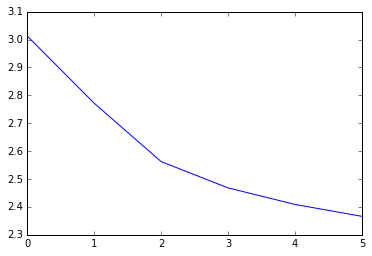

In [433]:
print "started RecommenderSGD"
startTime = time.time()
rg = RecommenderGradient()
rg.train(ratings[:20000])
endTime = time.time()
print "done"
print "took {} seconds".format(endTime - startTime)
plt.plot(rg.errors)

started RecommenderSGD
error  2.92364456063
error  2.68865621534
error  2.48618546395
error  2.31243049576
error  2.15998156681
done
took 11.7424690723 seconds


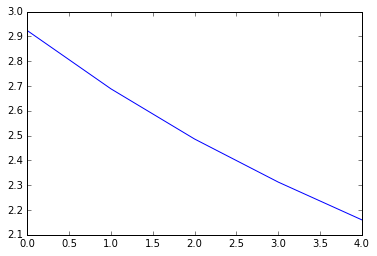

In [419]:
print "started RecommenderSGD"
startTime = time.time()
rs = RecommenderSGD()
rs.train(ratings[:20000])
endTime = time.time()
print "done"
print "took {} seconds".format(endTime - startTime)
plt.plot(rs.errors)

In [438]:
print ratings.shape
for i in ratings[2:20,]:
    print
    for m, r in rg.recommend(i[0,0]):
        print i[0,0], m, r
        print "-"

(1000209, 3)

2453 [[1748 3856 1231 ...,  767  493 3540]] [[ 0.98006859  1.11519179  1.1176878  ...,  4.50553535  4.6207094
   4.75675329]]
-

1449 [[ 390  241 1748 ..., 1224 3327 3540]] [[ 0.65223398  0.77820371  0.79316939 ...,  3.60726632  3.63947632
   3.65597613]]
-

1449 [[ 390  241 1748 ..., 1224 3327 3540]] [[ 0.65223398  0.77820371  0.79316939 ...,  3.60726632  3.63947632
   3.65597613]]
-

3737 [[ 510 1231 3329 ..., 1355 3930  560]] [[ 0.68627389  0.79602455  0.86127626 ...,  3.34033175  3.38465274
   3.58010627]]
-

5170 [[3856 3329  795 ...,  916 3327   81]] [[ 0.9284452   0.94581281  0.94714043 ...,  3.85325689  3.86017749
   4.01912436]]
-

4699 [[ 795 1748 3856 ...,  916  767 3540]] [[ 1.28028053  1.31487603  1.35770686 ...,  5.21044471  5.22750852
   5.37099154]]
-

5716 [[3329 1748  390 ...,  560 2199  558]] [[ 0.75119636  0.7612062   0.78880729 ...,  3.44974483  3.45900901
   3.54322513]]
-

1282 [[1748 3856 1231 ...,  916  767 3540]] [[ 1.2001469   1.31924974  1.3725